In [1]:
import numpy as np
import numpy.random as npr
import torch
from torch.nn import functional as F
from torch.distributions.normal import Normal
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR
import matplotlib.pyplot as pt
import copy

from variational_dense import *

In [2]:
def generate_data(n_data, x_min, x_max, weight, bias, noise):
    n_dim = len(x_min)
    x = npr.rand(n_data, n_dim)
    for i in range(n_dim):
        x[:, i] = x[:, i]*(x_max[i]-x_min[i])+x_min[i]
    y1 = np.dot(x, weight)+bias+npr.randn(n_data)*noise
    y2 = np.dot(x, weight)+bias+npr.randn(n_data)*noise
    
    return x, y1, y2

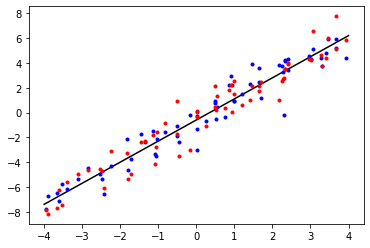

In [3]:
n_data = 64
x_min = [-4]
x_max = [4]
weight = [1.7]
bias = -0.6
noise = 1

npr.seed(1234)
x, y1, y2 = generate_data(n_data, x_min, x_max, weight, bias, noise)

x_theo = np.array([x_min[0], x_max[0]])
y_theo = weight[0]*x_theo+bias

pt.figure(1)
pt.plot(x_theo, y_theo, 'k-')
pt.plot(x, y1, 'b.')
pt.plot(x, y2, 'r.')
pt.show()

In [4]:
def fit_linear(x, y, Lambda_scale=0):
    x_extend = np.hstack((x, np.ones((x.shape[0], 1))))
    mat = np.einsum('ij, ik->jk', x_extend, x_extend)
    for i in range(mat.shape[0]-1):
        mat[i, i] += Lambda_scale
    vec = np.dot(y, x_extend)
    params = np.linalg.solve(mat, vec)
    return params

In [5]:
def fit_linear_bootstrap(x, y, Lambda_scale=0, n_bootstrap=100):
    n_data = x.shape[0]
    n_dim = x.shape[1]+1
    params = np.zeros((n_bootstrap, n_dim))
    for i in range(n_bootstrap):
        idx_bootstrap = npr.choice(n_data, n_data)
        x_bootstrap = x[idx_bootstrap]
        y_bootstrap = y[idx_bootstrap]
        params[i] = fit_linear(x_bootstrap, y_bootstrap, Lambda_scale=Lambda_scale)
        
    return np.mean(params, axis=0), np.std(params, axis=0, ddof=1)

In [6]:
def fit_linear_theory_1d(x, y):
    x = x.squeeze()
    n_data = len(x)
    x_avg = np.mean(x)
    y_avg = np.mean(y)
    SSxx = np.sum((x-x_avg)**2)
    SSxy = np.sum((x-x_avg)*(y-y_avg))
    w = SSxy/SSxx
    b = y_avg-w*x_avg
    SSE = np.sum((y-(w*x+b))**2)
    w_std = np.sqrt(SSE/(n_data-2)/SSxx)
    b_std = np.sqrt(SSE/(n_data-2)*(1/n_data+x_avg**2/SSxx))
    return [w, b], [w_std, b_std]

In [7]:
def fit_variational_linear(x, y1, y2, y_noise, Lambda=0, init_sigma=0.5,
                           lr_min=1e-5, lr_max=1e-3, n_batch=1, n_epoch=100):
    model = VariationalLinear(in_features=x.shape[1],
                              out_features=1,
                              init_sigma=init_sigma)
    
    x_train = torch.from_numpy(x.astype(np.float32))
    y_train = torch.from_numpy(y1.astype(np.float32)).view(-1, 1)
    y_valid = torch.from_numpy(y2.astype(np.float32)).view(-1, 1)

    n_data = x_train.size()[0]
    n_step = np.int(np.ceil(n_data/n_batch))
    
    optimizer = Adam(model.parameters(), lr=lr_min)
    scheduler = CyclicLR(optimizer, base_lr=lr_min, max_lr=lr_max,
                         step_size_up=1000, cycle_momentum=False)

    if Lambda>0:
        norm_prior = Normal(loc=0, scale=np.sqrt(1/Lambda))
    
    mse_train_history = []
    mse_valid_history = []
    mse_valid_min = np.inf
    for j in range(n_epoch):
        idx = npr.choice(n_data, n_data, replace=False)
        for i in range(n_step):
            idx_batch = idx[i*n_batch:(i+1)*n_batch]
            x_batch = x_train[idx_batch]
            y_train_batch = y_train[idx_batch]
            y_valid_batch = y_valid[idx_batch]
            
            model.train(True)
            yhat_batch, params_batch = model(x_batch)

            norm_y_batch = Normal(loc=y_train_batch, scale=y_noise)
            log_likelihood = torch.mean(norm_y_batch.log_prob(yhat_batch))*n_data
            
            norm_W = Normal(loc=params_batch[0], scale=params_batch[1])
            norm_b = Normal(loc=params_batch[3], scale=params_batch[4])
            log_varia_prob = torch.sum(norm_W.log_prob(params_batch[2])) \
                           + torch.sum(norm_b.log_prob(params_batch[5]))

            loss = log_varia_prob-log_likelihood

            if Lambda>0:
                loss -= torch.sum(norm_prior.log_prob(params_batch[2]))

            mse_train_history.append(torch.mean((yhat_batch-y_train_batch)**2).item())
            mse_valid_history.append(torch.mean((yhat_batch-y_valid_batch)**2).item())
            if mse_valid_history[-1]<mse_valid_min:
                best_valid_model = copy.deepcopy(model)
                mse_valid_min = mse_valid_history[-1]
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1e5)
            optimizer.step()
            scheduler.step()

    return best_valid_model, model, mse_train_history, mse_valid_history

In [8]:
n_data = 64
x_min = [-4]
x_max = [4]
weight = [1.7]
bias = -0.6
noise = 1

npr.seed(1234)
x, y1, y2 = generate_data(n_data, x_min, x_max, weight, bias, noise)
y_true = np.dot(x, weight)+bias

noise_obs = np.std(y1-y_true, ddof=1)
print(noise, noise_obs)

params_bs, params_std_bs = fit_linear_bootstrap(x, y1, n_bootstrap=1000)
print(params_bs, params_std_bs)

params_theo, params_std_theo = fit_linear_theory_1d(x, y1)
print(params_theo, params_std_theo)

1 0.9989748266909462
[ 1.67167925 -0.56197889] [0.04871872 0.12253597]
[1.6734045011865197, -0.5615962331038936] [0.05662965667600486, 0.12649961953391095]


In [9]:
lr_min = 1e-4
lr_max = 1e-2
init_sigma = 0.5
n_epoch = 2000

n_batch = n_data
best_valid_model, last_model, mse_train_history, mse_valid_history = \
fit_variational_linear(x, y1, y2, y_noise=noise_obs,
                       init_sigma=init_sigma,
                       lr_min=lr_min, lr_max=lr_max,
                       n_batch=n_batch, n_epoch=n_epoch)

print('best validation model')
for i, param in enumerate(best_valid_model.parameters()):
    if i<2:
        print(param.data)
    else:
        print(torch.abs(param.data))
        
print('\nlast model')
for i, param in enumerate(last_model.parameters()):
    if i<2:
        print(param.data)
    else:
        print(torch.abs(param.data))

best validation model
tensor([[1.6743]])
tensor([-0.5451])
tensor([[0.0564]])
tensor([0.1178])

last model
tensor([[1.6742]])
tensor([-0.5728])
tensor([[0.0582]])
tensor([0.1173])


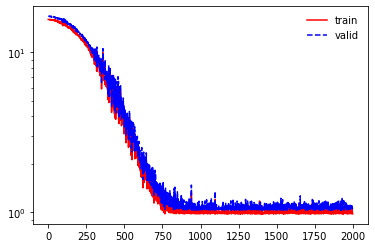

In [10]:
pt.figure(1)
pt.yscale('log')
pt.plot(np.arange(len(mse_train_history)), mse_train_history, 'r-', label='train')
pt.plot(np.arange(len(mse_valid_history)), mse_valid_history, 'b--', label='valid')
pt.legend(loc='upper right', frameon=False)
pt.show()

In [11]:
n_data = 128
x_min = [-4, -4]
x_max = [4, 4]
weight = [1.7, 2.1]
bias = -0.6
noise = 0.1

npr.seed(1234)
x, y1, y2 = generate_data(n_data, x_min, x_max, weight, bias, noise)
y_true = np.dot(x, weight)+bias

noise_obs = np.std(y1-y_true, ddof=1)
print(noise, noise_obs)

params_bs, params_std_bs = fit_linear_bootstrap(x, y1, n_bootstrap=1000)
print(params_bs, params_std_bs)

0.1 0.09305022165078441
[ 1.70287721  2.10048198 -0.58275064] [0.00336766 0.00366834 0.00824353]


In [14]:
lr_min = 1e-4
lr_max = 1e-2
init_sigma = 0.5
n_epoch = 2000

n_batch = n_data
best_valid_model, last_model, mse_train_history, mse_valid_history = \
fit_variational_linear(x, y1, y2, y_noise=noise_obs,
                       init_sigma=init_sigma,
                       lr_min=lr_min, lr_max=lr_max,
                       n_batch=n_batch, n_epoch=n_epoch)

print('best validation model')
for i, param in enumerate(best_valid_model.parameters()):
    if i<2:
        print(param.data)
    else:
        print(torch.abs(param.data))
        
print('\nlast model')
for i, param in enumerate(last_model.parameters()):
    if i<2:
        print(param.data)
    else:
        print(torch.abs(param.data))

best validation model
tensor([[1.7030, 2.1005]])
tensor([-0.5905])
tensor([[0.0037, 0.0037]])
tensor([0.0112])

last model
tensor([[1.7026, 2.1003]])
tensor([-0.5813])
tensor([[0.0036, 0.0034]])
tensor([0.0077])


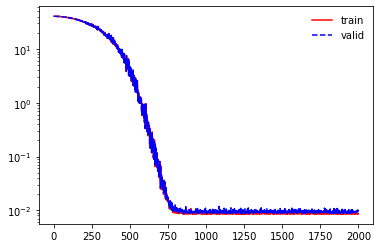

In [15]:
pt.figure(1)
pt.yscale('log')
pt.plot(np.arange(len(mse_train_history)), mse_train_history, 'r-', label='train')
pt.plot(np.arange(len(mse_valid_history)), mse_valid_history, 'b--', label='valid')
pt.legend(loc='upper right', frameon=False)
pt.show()

In [16]:
n_data = 128
x_min = [-4]
x_max = [4]
weight = [1.7]
bias = -0.6
noise = 1

npr.seed(1234)
x, y1, y2 = generate_data(n_data, x_min, x_max, weight, bias, noise)
y_true = np.dot(x, weight)+bias
x_random = npr.rand(n_data, 1)*(x_max[0]-x_min[0])+x_min[0]
x = np.hstack((x, x_random))

noise_obs = np.std(y1-y_true, ddof=1)
print(noise, noise_obs)

params_bs, params_std_bs = fit_linear_bootstrap(x, y1, n_bootstrap=1000)
print(params_bs, params_std_bs)

1 1.003895838591033
[ 1.76542005  0.00353188 -0.57427735] [0.03929389 0.03327734 0.08829833]


In [17]:
lr_min = 1e-4
lr_max = 1e-2
init_sigma = 0.5
n_epoch = 2000

n_batch = n_data
best_valid_model, last_model, mse_train_history, mse_valid_history = \
fit_variational_linear(x, y1, y2, y_noise=noise_obs,
                       init_sigma=init_sigma,
                       lr_min=lr_min, lr_max=lr_max,
                       n_batch=n_batch, n_epoch=n_epoch)


print('best validation model')
for i, param in enumerate(best_valid_model.parameters()):
    if i<2:
        print(param.data)
    else:
        print(torch.abs(param.data))
        
print('\nlast model')
for i, param in enumerate(last_model.parameters()):
    if i<2:
        print(param.data)
    else:
        print(torch.abs(param.data))

best validation model
tensor([[1.7692e+00, 1.1922e-03]])
tensor([-0.5547])
tensor([[0.0421, 0.0342]])
tensor([0.0898])

last model
tensor([[1.7651e+00, 8.7477e-04]])
tensor([-0.5810])
tensor([[0.0408, 0.0369]])
tensor([0.0858])


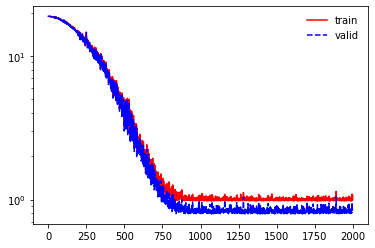

In [18]:
pt.figure(1)
pt.yscale('log')
pt.plot(np.arange(len(mse_train_history)), mse_train_history, 'r-', label='train')
pt.plot(np.arange(len(mse_valid_history)), mse_valid_history, 'b--', label='valid')
pt.legend(loc='upper right', frameon=False)
pt.show()

In [20]:
n_data = 128
x_min = [-4]
x_max = [4]
weight = [1.7]
bias = -0.6
noise = 1

npr.seed(1234)
x, y1, y2 = generate_data(n_data, x_min, x_max, weight, bias, noise)
y_true = np.dot(x, weight)+bias

noise_obs = np.std(y1-y_true, ddof=1)
print(noise, noise_obs)

Lambda = 1e2
Lambda_scale = Lambda*noise_obs**2

params_bs, params_std_bs = fit_linear_bootstrap(x, y1, Lambda_scale=Lambda_scale, n_bootstrap=1000)
print(params_bs, params_std_bs)

1 1.003895838591033
[ 1.52352082 -0.52482072] [0.03867773 0.10078536]


In [21]:
lr_min = 1e-4
lr_max = 1e-2
init_sigma = 0.5
n_epoch = 2000

n_batch = n_data
best_valid_model, last_model, mse_train_history, mse_valid_history = \
fit_variational_linear(x, y1, y2, y_noise=noise_obs,
                       Lambda=Lambda, init_sigma=init_sigma,
                       lr_min=lr_min, lr_max=lr_max,
                       n_batch=n_batch, n_epoch=n_epoch)

print('best validation model')
for i, param in enumerate(best_valid_model.parameters()):
    if i<2:
        print(param.data)
    else:
        print(torch.abs(param.data))
        
print('\nlast model')
for i, param in enumerate(last_model.parameters()):
    if i<2:
        print(param.data)
    else:
        print(torch.abs(param.data))

best validation model
tensor([[1.5265]])
tensor([-0.5119])
tensor([[0.0420]])
tensor([0.0880])

last model
tensor([[1.5285]])
tensor([-0.5330])
tensor([[0.0366]])
tensor([0.0882])


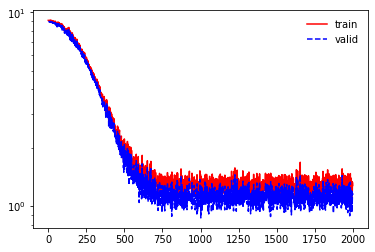

In [22]:
pt.figure(1)
pt.yscale('log')
pt.plot(np.arange(len(mse_train_history)), mse_train_history, 'r-', label='train')
pt.plot(np.arange(len(mse_valid_history)), mse_valid_history, 'b--', label='valid')
pt.legend(loc='upper right', frameon=False)
pt.show()